# PolyQ Rotamers Analysis  - General

### Libraries of interest 

In [8]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import pandas as pd
import mdtraj as md
import scipy.stats as st
import nglview as nv
import MDAnalysis as mda
from nglview.datafiles import PDB,XTC
from scipy.spatial.distance import cdist
%matplotlib inline
import os
import matplotlib.pyplot as plt
from matplotlib import cm
#from scipy.stats import gaussian_kde
from Bio.SeqUtils import IUPACData
from __future__ import print_function
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import itertools
import mdtraj.testing
from itertools import product

### Kernel density estimation

In [9]:
class gaussian_kde(object):
    """Representation of a kernel-density estimate using Gaussian kernels.

    Kernel density estimation is a way to estimate the probability density
    function (PDF) of a random variable in a non-parametric way.
    `gaussian_kde` works for both uni-variate and multi-variate data.   It
    includes automatic bandwidth determination.  The estimation works best for
    a unimodal distribution; bimodal or multi-modal distributions tend to be
    oversmoothed.

    Parameters
    ----------
    dataset : array_like
        Datapoints to estimate from. In case of univariate data this is a 1-D
        array, otherwise a 2-D array with shape (# of dims, # of data).
    bw_method : str, scalar or callable, optional
        The method used to calculate the estimator bandwidth.  This can be
        'scott', 'silverman', a scalar constant or a callable.  If a scalar,
        this will be used directly as `kde.factor`.  If a callable, it should
        take a `gaussian_kde` instance as only parameter and return a scalar.
        If None (default), 'scott' is used.  See Notes for more details.
    weights : array_like, shape (n, ), optional, default: None
        An array of weights, of the same shape as `x`.  Each value in `x`
        only contributes its associated weight towards the bin count
        (instead of 1).

    Attributes
    ----------
    dataset : ndarray
        The dataset with which `gaussian_kde` was initialized.
    d : int
        Number of dimensions.
    n : int
        Number of datapoints.
    neff : float
        Effective sample size using Kish's approximation.
    factor : float
        The bandwidth factor, obtained from `kde.covariance_factor`, with which
        the covariance matrix is multiplied.
    covariance : ndarray
        The covariance matrix of `dataset`, scaled by the calculated bandwidth
        (`kde.factor`).
    inv_cov : ndarray
        The inverse of `covariance`.

    Methods
    -------
    kde.evaluate(points) : ndarray
        Evaluate the estimated pdf on a provided set of points.
    kde(points) : ndarray
        Same as kde.evaluate(points)
    kde.pdf(points) : ndarray
        Alias for ``kde.evaluate(points)``.
    kde.set_bandwidth(bw_method='scott') : None
        Computes the bandwidth, i.e. the coefficient that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        .. versionadded:: 0.11.0
    kde.covariance_factor : float
        Computes the coefficient (`kde.factor`) that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        The default is `scotts_factor`.  A subclass can overwrite this method
        to provide a different method, or set it through a call to
        `kde.set_bandwidth`.

    Notes
    -----
    Bandwidth selection strongly influences the estimate obtained from the KDE
    (much more so than the actual shape of the kernel).  Bandwidth selection
    can be done by a "rule of thumb", by cross-validation, by "plug-in
    methods" or by other means; see [3]_, [4]_ for reviews.  `gaussian_kde`
    uses a rule of thumb, the default is Scott's Rule.

    Scott's Rule [1]_, implemented as `scotts_factor`, is::

        n**(-1./(d+4)),

    with ``n`` the number of data points and ``d`` the number of dimensions.
    Silverman's Rule [2]_, implemented as `silverman_factor`, is::

        (n * (d + 2) / 4.)**(-1. / (d + 4)).

    Good general descriptions of kernel density estimation can be found in [1]_
    and [2]_, the mathematics for this multi-dimensional implementation can be
    found in [1]_.

    References
    ----------
    .. [1] D.W. Scott, "Multivariate Density Estimation: Theory, Practice, and
           Visualization", John Wiley & Sons, New York, Chicester, 1992.
    .. [2] B.W. Silverman, "Density Estimation for Statistics and Data
           Analysis", Vol. 26, Monographs on Statistics and Applied Probability,
           Chapman and Hall, London, 1986.
    .. [3] B.A. Turlach, "Bandwidth Selection in Kernel Density Estimation: A
           Review", CORE and Institut de Statistique, Vol. 19, pp. 1-33, 1993.
    .. [4] D.M. Bashtannyk and R.J. Hyndman, "Bandwidth selection for kernel
           conditional density estimation", Computational Statistics & Data
           Analysis, Vol. 36, pp. 279-298, 2001.

    Examples
    --------
    Generate some random two-dimensional data:

    >>> from scipy import stats
    >>> def measure(n):
    >>>     "Measurement model, return two coupled measurements."
    >>>     m1 = np.random.normal(size=n)
    >>>     m2 = np.random.normal(scale=0.5, size=n)
    >>>     return m1+m2, m1-m2

    >>> m1, m2 = measure(2000)
    >>> xmin = m1.min()
    >>> xmax = m1.max()
    >>> ymin = m2.min()
    >>> ymax = m2.max()

    Perform a kernel density estimate on the data:

    >>> X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    >>> positions = np.vstack([X.ravel(), Y.ravel()])
    >>> values = np.vstack([m1, m2])
    >>> kernel = stats.gaussian_kde(values)
    >>> Z = np.reshape(kernel(positions).T, X.shape)

    Plot the results:

    >>> import matplotlib.pyplot as plt
    >>> fig = plt.figure()
    >>> ax = fig.add_subplot(111)
    >>> ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
    ...           extent=[xmin, xmax, ymin, ymax])
    >>> ax.plot(m1, m2, 'k.', markersize=2)
    >>> ax.set_xlim([xmin, xmax])
    >>> ax.set_ylim([ymin, ymax])
    >>> plt.show()

    """
    def __init__(self, dataset, bw_method=None, weights=None):
        self.dataset = np.atleast_2d(dataset)
        if not self.dataset.size > 1:
            raise ValueError("`dataset` input should have multiple elements.")
        self.d, self.n = self.dataset.shape
            
        if weights is not None:
            self.weights = weights / np.sum(weights)
        else:
            self.weights = np.ones(self.n) / self.n
            
        # Compute the effective sample size 
        # http://surveyanalysis.org/wiki/Design_Effects_and_Effective_Sample_Size#Kish.27s_approximate_formula_for_computing_effective_sample_size
        self.neff = 1.0 / np.sum(self.weights ** 2)

        self.set_bandwidth(bw_method=bw_method)

    def evaluate(self, points):
        """Evaluate the estimated pdf on a set of points.

        Parameters
        ----------
        points : (# of dimensions, # of points)-array
            Alternatively, a (# of dimensions,) vector can be passed in and
            treated as a single point.

        Returns
        -------
        values : (# of points,)-array
            The values at each point.

        Raises
        ------
        ValueError : if the dimensionality of the input points is different than
                     the dimensionality of the KDE.

        """
        points = np.atleast_2d(points)

        d, m = points.shape
        if d != self.d:
            if d == 1 and m == self.d:
                # points was passed in as a row vector
                points = np.reshape(points, (self.d, 1))
                m = 1
            else:
                msg = "points have dimension %s, dataset has dimension %s" % (d,
                    self.d)
                raise ValueError(msg)

        # compute the normalised residuals
        chi2 = cdist(points.T, self.dataset.T, 'mahalanobis', VI=self.inv_cov) ** 2
        # compute the pdf
        result = np.sum(np.exp(-.5 * chi2) * self.weights, axis=1) / self._norm_factor

        return result

    __call__ = evaluate

    def scotts_factor(self):
        return np.power(self.neff, -1./(self.d+4))

    def silverman_factor(self):
        return np.power(self.neff*(self.d+2.0)/4.0, -1./(self.d+4))

    #  Default method to calculate bandwidth, can be overwritten by subclass
    covariance_factor = scotts_factor

    def set_bandwidth(self, bw_method=None):
        """Compute the estimator bandwidth with given method.

        The new bandwidth calculated after a call to `set_bandwidth` is used
        for subsequent evaluations of the estimated density.

        Parameters
        ----------
        bw_method : str, scalar or callable, optional
            The method used to calculate the estimator bandwidth.  This can be
            'scott', 'silverman', a scalar constant or a callable.  If a
            scalar, this will be used directly as `kde.factor`.  If a callable,
            it should take a `gaussian_kde` instance as only parameter and
            return a scalar.  If None (default), nothing happens; the current
            `kde.covariance_factor` method is kept.

        Notes
        -----
        .. versionadded:: 0.11

        Examples
        --------
        >>> x1 = np.array([-7, -5, 1, 4, 5.])
        >>> kde = stats.gaussian_kde(x1)
        >>> xs = np.linspace(-10, 10, num=50)
        >>> y1 = kde(xs)
        >>> kde.set_bandwidth(bw_method='silverman')
        >>> y2 = kde(xs)
        >>> kde.set_bandwidth(bw_method=kde.factor / 3.)
        >>> y3 = kde(xs)

        >>> fig = plt.figure()
        >>> ax = fig.add_subplot(111)
        >>> ax.plot(x1, np.ones(x1.shape) / (4. * x1.size), 'bo',
        ...         label='Data points (rescaled)')
        >>> ax.plot(xs, y1, label='Scott (default)')
        >>> ax.plot(xs, y2, label='Silverman')
        >>> ax.plot(xs, y3, label='Const (1/3 * Silverman)')
        >>> ax.legend()
        >>> plt.show()

        """
        if bw_method is None:
            pass
        elif bw_method == 'scott':
            self.covariance_factor = self.scotts_factor
        elif bw_method == 'silverman':
            self.covariance_factor = self.silverman_factor
        elif np.isscalar(bw_method) and not isinstance(bw_method, string_types):
            self._bw_method = 'use constant'
            self.covariance_factor = lambda: bw_method
        elif callable(bw_method):
            self._bw_method = bw_method
            self.covariance_factor = lambda: self._bw_method(self)
        else:
            msg = "`bw_method` should be 'scott', 'silverman', a scalar " \
                  "or a callable."
            raise ValueError(msg)

        self._compute_covariance()

    def _compute_covariance(self):
        """Computes the covariance matrix for each Gaussian kernel using
        covariance_factor().
        """
        self.factor = self.covariance_factor()
        # Cache covariance and inverse covariance of the data
        if not hasattr(self, '_data_inv_cov'):
            # Compute the mean and residuals
            _mean = np.sum(self.weights * self.dataset, axis=1)
            _residual = (self.dataset - _mean[:, None])
            # Compute the biased covariance
            self._data_covariance = np.atleast_2d(np.dot(_residual * self.weights, _residual.T))
            # Correct for bias (http://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_covariance)
            self._data_covariance /= (1 - np.sum(self.weights ** 2))
            self._data_inv_cov = np.linalg.inv(self._data_covariance)

        self.covariance = self._data_covariance * self.factor**2
        self.inv_cov = self._data_inv_cov / self.factor**2
        self._norm_factor = np.sqrt(np.linalg.det(2*np.pi*self.covariance)) #* self.n

### Functions used for this analysis

In [23]:
#1. Read the trajectory 
def read_trajectory (dirname, equil=0, temp=1):
    #Read the trajectory and save it 
    topname = os.path.join(dirname, 'prot.pdb')
    trajname = os.path.join(dirname, f'prod{temp}_prot.xtc')
    t = md.load(trajname, top=topname, stride=1)
    t = t[equil:]
    t.remove_solvent(inplace=True)
    return t

#2. Generate other trajectories
#2.1. Generate another trajectory considering ONLY the frames where residues from x to y are helical
def helix_trajectory (t):
    ss = md.compute_dssp(t,simplified=True)
    ssh = (ss=='H').astype(np.float)
    t_helix = t[np.all(ssh[:,6:13]>0,1)]
    return t_helix

#2.2. Coil trajectory
def coil_trajectory (t):
    ss = md.compute_dssp(t,simplified=True)
    ssc = (ss=='C').astype(np.float)
    t_coil = t[np.all(ssc[:,16:19]>0,1)]
    return t_coil

#2.3. Q1/Q5 Helical + sc-mc hbond trajectories
def t_hbond_trajectory (t_helix, d_helix1, d_helix3):
    t_hbond1 = t_helix[d_helix1<2.4]
    t_hbond3 = t_helix[d_helix3<2.4]
    return t_hbond1, t_hbond3

#2.4. Select the trajectories ONLY for the atoms of interest
def atoms_trajectory (t_helix, t_hbond1, t_hbond3):
    L1_helix = t_helix.topology.select('residue 7')
    t_helix_L1 = t_helix.atom_slice(L1_helix)
    
    L3_helix = t_helix.topology.select('residue 9')
    t_helix_L3 = t_helix.atom_slice(L3_helix)
    
    L1_hbond = t_hbond1.topology.select('residue 7')
    t_hbond_L1 = t_hbond1.atom_slice(L1_hbond)
    
    L3_hbond = t_hbond3.topology.select('residue 9')
    t_hbond_L3 = t_hbond3.atom_slice(L3_hbond)
    
    return t_helix_L1, t_helix_L3, t_hbond_L1, t_hbond_L3
  

#3.Hydrogen bond distances: As we are going to study the different conformations that the same amino acid has
# depending on its condition, to select some frames or others, we first have to measure the distance between atoms

#3.1. Q1sc(i)-L1mc(i-4) hydrogen bond distance
def distance_hbond1 (t_helix):
    donors_helix1 = t_helix.topology.select('residue 11 and name HE1 HE2 HE21 HE22')
    if donors_helix1.size==0: 
        np.array([9999.])
    #Selecting the oxigen of L1
    acceptor_helix1 = t_helix.topology.select('residue 7 and name O')
    pairs_helix1 = list(product(donors_helix1, acceptor_helix1))
    try:
        d_helix1 = md.compute_distances(t_helix, pairs_helix1)
        #We take the shortest distance
        d_helix1 = d_helix1.min(1)
        d_helix1 *= 10 #to angstroms
    except:
        d_helix1 = [0]*(int(len(t_helix)))
    return d_helix1

#3.2. Q5sc(i)-Q1mc(i-4) hydrogen bond distance
def distance_hbond3 (t_helix):
    donors_helix3 = t_helix.topology.select('residue 13 and name HE1 HE2 HE21 HE22')
    if donors_helix3.size==0: 
        np.array([9999.])
    #Selecting the oxigen of L1
    acceptor_helix3 = t_helix.topology.select('residue 9 and name O')
    pairs_helix3 = list(product(donors_helix3, acceptor_helix3))
    try:
        d_helix3 = md.compute_distances(t_helix, pairs_helix3)
        #We take the shortest distance
        d_helix3 = d_helix3.min(1)
        d_helix3 *= 10 #to angstroms
    except:
        d_helix3 = [0]*(int(len(t_helix)))
    return d_helix3


# 4. Calculate the chi1, chi2 and chi3 dihedrals angles for the L

def calculate_chi1 (t_helix_L1, t_helix_L3, t_hbond_L1, t_hbond_L3):
    chis1_L1_helix = md.compute_chi1(t_helix_L1)[1]
    chis1_L1_helix = np.rad2deg(np.where(chis1_L1_helix<0,chis1_L1_helix+2*np.pi,chis1_L1_helix ))
    chis1_L1_helix = list(chis1_L1_helix[:,0])
    
    chis1_L3_helix = md.compute_chi1(t_helix_L3)[1]
    chis1_L3_helix = np.rad2deg(np.where(chis1_L3_helix<0,chis1_L3_helix+2*np.pi,chis1_L3_helix ))
    chis1_L3_helix = list(chis1_L3_helix[:,0])
    
    chis1_L1_hbond = md.compute_chi1(t_hbond_L1)[1]
    chis1_L1_hbond = np.rad2deg(np.where(chis1_L1_hbond<0,chis1_L1_hbond+2*np.pi,chis1_L1_hbond ))
    chis1_L1_hbond = list(chis1_L1_hbond[:,0])
    
    chis1_L3_hbond = md.compute_chi1(t_hbond_L3)[1]
    chis1_L3_hbond = np.rad2deg(np.where(chis1_L3_hbond<0,chis1_L3_hbond+2*np.pi,chis1_L3_hbond ))
    chis1_L3_hbond = list(chis1_L3_hbond[:,0])
    
    return chis1_L1_helix, chis1_L3_helix, chis1_L1_hbond, chis1_L3_hbond

# 4.2. Calculate chi2
def calculate_chi2 (t_helix_L1, t_helix_L3, t_hbond_L1, t_hbond_L3):
    chis2_L1_helix = md.compute_chi2(t_helix_L1)[1]
    chis2_L1_helix = np.rad2deg(np.where(chis2_L1_helix<0,chis2_L1_helix+2*np.pi,chis2_L1_helix ))
    chis2_L1_helix = list(chis2_L1_helix[:,0])
    
    chis2_L3_helix = md.compute_chi2(t_helix_L3)[1]
    chis2_L3_helix = np.rad2deg(np.where(chis2_L3_helix<0,chis2_L3_helix+2*np.pi,chis2_L3_helix ))
    chis2_L3_helix = list(chis2_L3_helix[:,0])
    
    chis2_L1_hbond = md.compute_chi2(t_hbond_L1)[1]
    chis2_L1_hbond = np.rad2deg(np.where(chis2_L1_hbond<0,chis2_L1_hbond+2*np.pi,chis2_L1_hbond ))
    chis2_L1_hbond = list(chis2_L1_hbond[:,0])
    
    chis2_L3_hbond = md.compute_chi2(t_hbond_L3)[1]
    chis2_L3_hbond = np.rad2deg(np.where(chis2_L3_hbond<0,chis2_L3_hbond+2*np.pi,chis2_L3_hbond ))
    chis2_L3_hbond = list(chis2_L3_hbond[:,0])
    
    
    return chis2_L1_helix, chis2_L3_helix, chis2_L1_hbond, chis2_L3_hbond




### Upload the trajectories

Q1EH_DES-amber
<mdtraj.Trajectory with 12407 frames, 412 atoms, 24 residues, and unitcells>
Q1EH_a99SB-disp
<mdtraj.Trajectory with 12302 frames, 412 atoms, 24 residues, and unitcells>


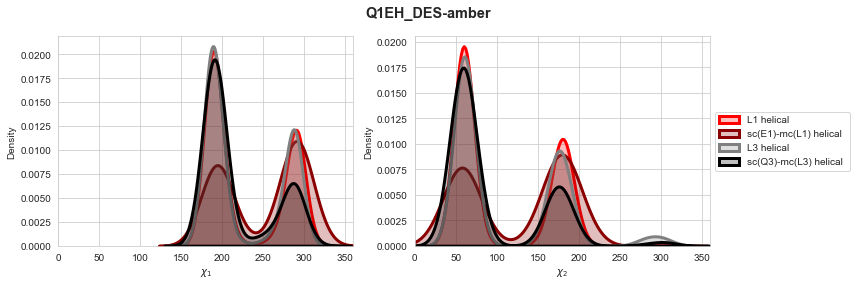

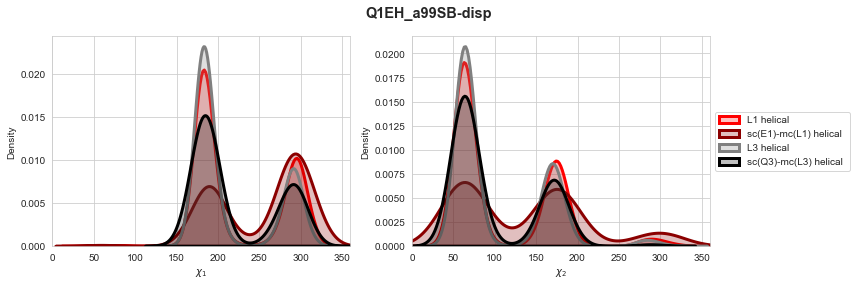

In [34]:
system_list = ('Q1EH_DES-amber','Q1EH_a99SB-disp')

t={}
t_helix={}
t_coil={}
t_hbond1={}
t_hbond3={}
t_helix_L1={} 
t_helix_L3={}
t_hbond_L1={}
t_hbond_L3={}
d_helix1={}
d_helix3={}
chis1_L1_helix={}
chis1_L3_helix={}
chis1_L1_hbond={}
chis1_L3_hbond={}
chis2_L1_helix={} 
chis2_L3_helix={}
chis2_L1_hbond={}
chis2_L3_hbond={}



for system in system_list:
    path = f'/home/lourdes/TFM-LOURDES/data/ALL/{system}'
    #first we have to read the trajectories 
    t[system] = read_trajectory(path, equil=0)
    print (system)
    #then we have to choose only the helical frames 
    t_helix[system] = helix_trajectory(t[system])
    print (t_helix[system])
    t_coil[system]=coil_trajectory(t[system])
    d_helix1[system]=distance_hbond1(t_helix[system])
    d_helix3[system]=distance_hbond3(t_helix[system])
    t_hbond1[system],t_hbond3[system]=t_hbond_trajectory(t_helix[system],d_helix1[system],d_helix3[system])
    t_helix_L1[system], t_helix_L3[system], t_hbond_L1[system], t_hbond_L3[system]=atoms_trajectory (t_helix[system], t_hbond1[system], t_hbond3[system])
    chis1_L1_helix[system], chis1_L3_helix[system], chis1_L1_hbond[system], chis1_L3_hbond[system]=calculate_chi1 (t_helix_L1[system], t_helix_L3[system], t_hbond_L1[system], t_hbond_L3[system])
    chis2_L1_helix[system], chis2_L3_helix[system], chis2_L1_hbond[system], chis2_L3_hbond[system]=calculate_chi2 (t_helix_L1[system], t_helix_L3[system], t_hbond_L1[system], t_hbond_L3[system])
    #chis3_L1_helix[system], chis3_L3_helix[system], chis3_L1_hbond[system], chis3_L3_hbond[system], chis3_Q12_coil[system]=calculate_chi3 (t_helix_L1[system], t_helix_L3[system], t_coil_Q12[system], t_hbond_L1[system], t_hbond_L3[system])
    
    fig = plt.figure(figsize=(12, 4))
    fig.suptitle(system, fontsize=14.5, fontweight="bold")
    sns.set_style('whitegrid')
    
    plt.subplot(121)
    sns.kdeplot(chis1_L1_helix[system],shade=True, label="L1 helical ", color='red', linewidth=3) 
    sns.kdeplot(chis1_L1_hbond[system],shade=True, label="L1 sc(E1)-mc(L1) helical ", color='darkred',linewidth=3)
    sns.kdeplot(chis1_L3_helix[system],shade=True, label="L3 helical ", color='grey', linewidth=3) 
    sns.kdeplot(chis1_L3_hbond[system],shade=True, label="L3 sc(Q3)-mc(L3) helical ", color='black',linewidth=3)
    #sns.kdeplot(chis1_Q12_coil[system],shade=True, label="Q12 coil ", color='olivedrab',linewidth=3)   
    #plt.legend(loc="center left", bbox_to_anchor=(0.8, 0.5))
    plt.xlabel(r'$\chi_1$',fontweight="bold")
    plt.xlim((0,360))
    
    plt.subplot(122)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
    sns.kdeplot(chis2_L1_helix[system],shade=True, label="L1 helical ", color='red',linewidth=3) 
    sns.kdeplot(chis2_L1_hbond[system],shade=True, label="L1 sc(E1)-mc(L1) helical ", color='darkred',linewidth=3)
    sns.kdeplot(chis2_L3_helix[system],shade=True, label="L3 helical ", color='grey', linewidth=3) 
    sns.kdeplot(chis2_L3_hbond[system],shade=True, label="L3 sc(Q3)-mc(L3) helical ", color='black',linewidth=3)
    #sns.kdeplot(chis2_Q12_coil[system],shade=True, label="Q12 coil ", color='olivedrab',linewidth=3)      
    #plt.legend(loc="upper left")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.xlabel(r'$\chi_2$',fontweight="bold")
    plt.xlim((0,360))
    
    

    plt.tight_layout()
    fig.savefig(f'/home/lourdes/Documents/RotamerDistribution{system}')



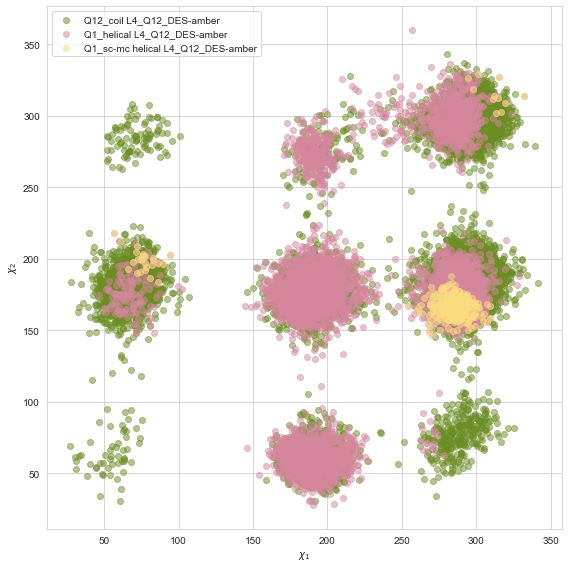

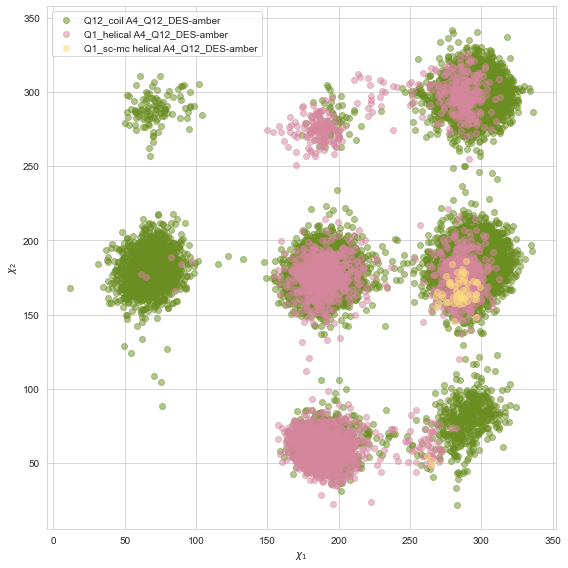

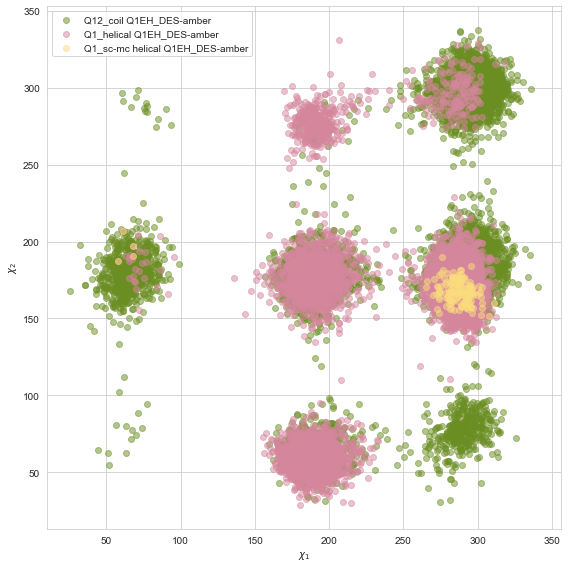

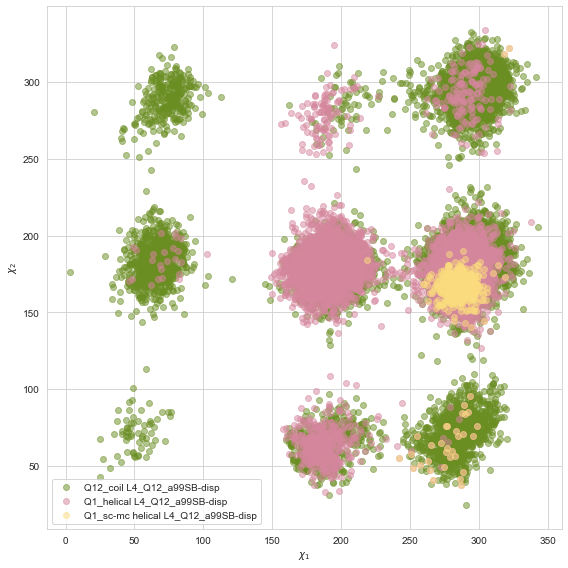

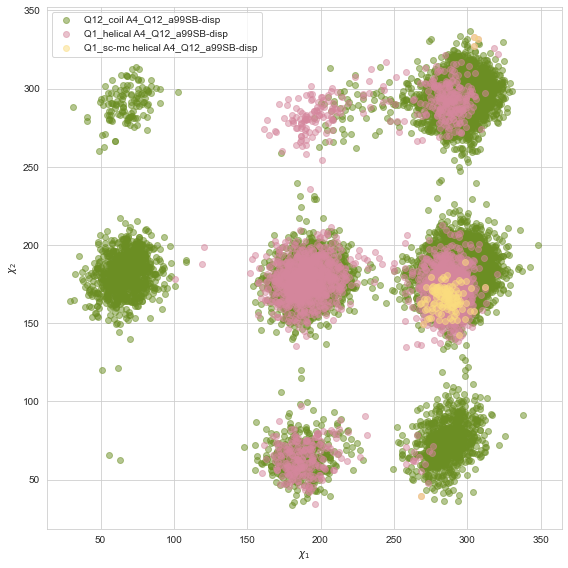

In [18]:
for system in system_list:
    path = f'/home/lourdes/TFM-LOURDES/data/ALL/{system}'
    plt.figure(figsize=(8,8))
    
    plt.scatter(chis1_Q12_coil[system],chis2_Q12_coil[system], marker='o', color='olivedrab', label="Q12_coil "+system, alpha=0.5) 
    plt.scatter(chis1_Q1_helix[system], chis2_Q1_helix[system], color='#d5869d', marker='o', label="Q1_helical "+system,alpha=0.5) 
    plt.scatter(chis1_Q1_hbond[system], chis2_Q1_hbond[system],color='#fbdd7e', marker='o', label="Q1_sc-mc helical "+system,alpha=0.5 )
    plt.xlabel(r'$\chi_1$');
    plt.ylabel(r'$\chi_2$');
    plt.legend(loc='best')
    
    plt.tight_layout()

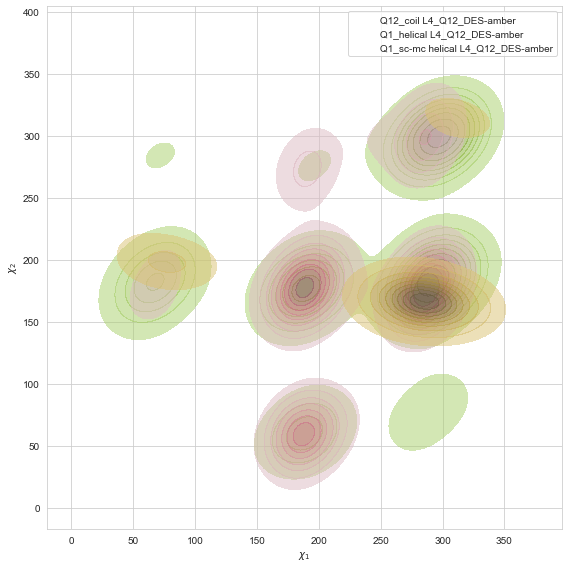

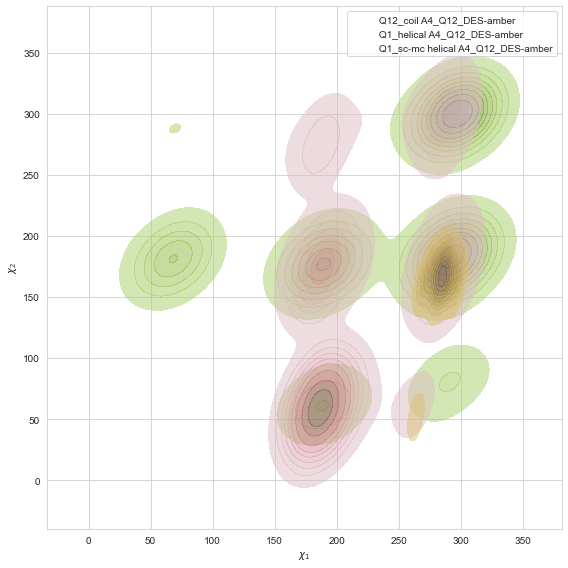

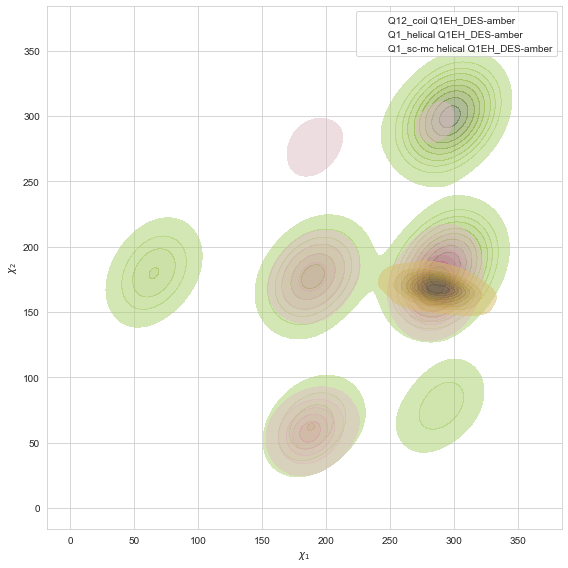

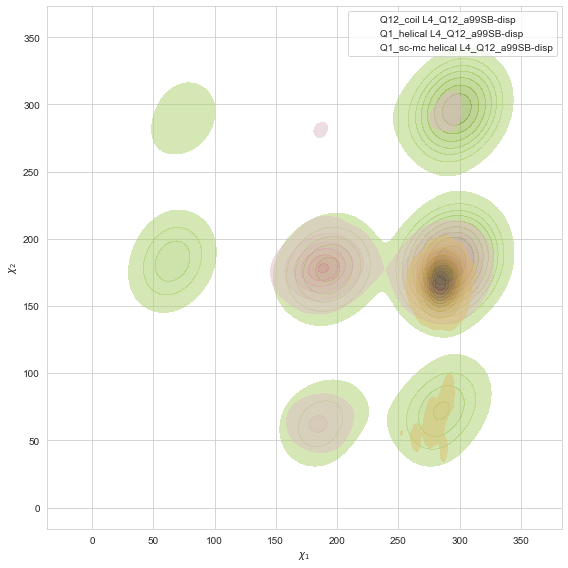

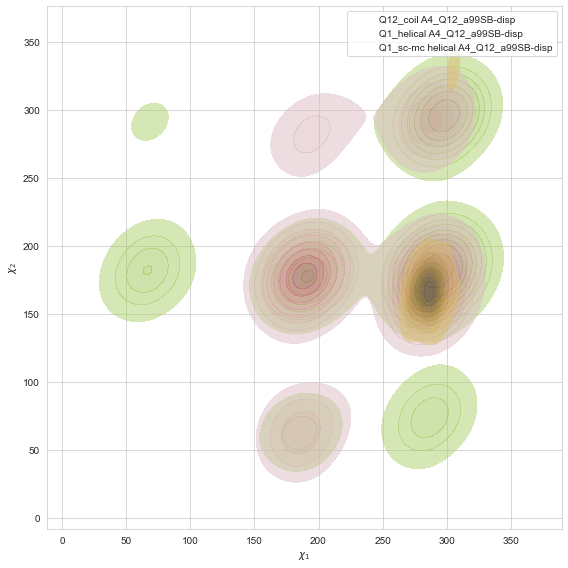

In [21]:
for system in system_list:
    path = f'/home/lourdes/TFM-LOURDES/data/ALL/{system}'
    plt.figure(figsize=(8,8))
    sns.kdeplot(x=chis1_Q12_coil[system],y=chis2_Q12_coil[system], color='olivedrab', shade='fill', label="Q12_coil "+system,alpha=0.5) 
    sns.kdeplot(x=chis1_Q1_helix[system], y=chis2_Q1_helix[system], color='#d5869d',  shade='fill', label="Q1_helical "+system,alpha=0.5) 
    sns.kdeplot(x=chis1_Q1_hbond[system], y=chis2_Q1_hbond[system], color='#fbdd7e', shade='fill', label="Q1_sc-mc helical "+system,alpha=0.5)
    plt.xlabel(r'$\chi_1$');
    plt.ylabel(r'$\chi_2$');
    plt.legend()
    
    plt.tight_layout()

In [30]:
import collections 

def mutate_dict(f,d):
    for k, v in d.items():
        d[k] = f(v)

def dict_L1_helix(chis1_L1_helix,chis2_L1_helix):
    L1_helix_rotamers = []
    for i,j in zip(chis1_L1_helix,chis2_L1_helix):
        if i <=120 and j<=120:
            rot = "pp"
            L1_helix_rotamers.append(rot)
        elif i<= 120 and (j>120 and j<=240):
            rot = "pt"
            L1_helix_rotamers.append(rot)
        elif i<= 120 and (j>240 and j<=360):
            rot = "pm"
            L1_helix_rotamers.append(rot)
        elif (i>120 and i<=240) and j<=120:
            rot = "tp"
            L1_helix_rotamers.append(rot)
        elif (i>120 and i<=240) and (j>120 and j<=240):
            rot = "tt"
            L1_helix_rotamers.append(rot)
        elif (i>120 and i<=240) and (j>240 and j<=360):
            rot = "tm"
            L1_helix_rotamers.append(rot)
        elif (i>240 and i<=360) and (j<=120):
            rot = "mp"
            L1_helix_rotamers.append(rot)
        elif (i>240 and i<=360) and (j>120 and j<=240):
            rot = "mt"
            L1_helix_rotamers.append(rot)
        else:
            rot = "mm"
            L1_helix_rotamers.append(rot)
    df_helix = pd.DataFrame(list(zip(chis1_L1_helix,chis2_L1_helix,L1_helix_rotamers)), 
              columns=['chi1','chi2','r1r2RotamersPopulation'])
    
    L1_helix_rotamers = collections.Counter(L1_helix_rotamers)
    
    L1_helix_rotamers.setdefault('pm', 0)
    L1_helix_rotamers.setdefault('pp', 0)
    L1_helix_rotamers.setdefault('pt', 0)
    L1_helix_rotamers.setdefault('mm', 0)
    L1_helix_rotamers.setdefault('mp', 0)
    L1_helix_rotamers.setdefault('mt', 0)
    L1_helix_rotamers.setdefault('tm', 0)
    L1_helix_rotamers.setdefault('tp', 0)
    L1_helix_rotamers.setdefault('tt', 0)
    
    L1_helix_rotamers = dict(sorted(L1_helix_rotamers.items()))
    #print(Q1_helix_rotamers)
    
    values_L1H = L1_helix_rotamers.values()
    factor1 = 100/sum(values_L1H)

    mutate_dict(lambda x: x*factor1, L1_helix_rotamers)
    print(L1_helix_rotamers)
    
    return L1_helix_rotamers


def dict_L1_hbond(chis1_L1_hbond,chis2_L1_hbond):
    L1_hbond_rotamers = []
    for i,j in zip(chis1_L1_hbond,chis2_L1_hbond):
        if i <=120 and j<=120:
            rot = "pp"
            L1_hbond_rotamers.append(rot)
        elif i<= 120 and (j>120 and j<=240):
            rot = "pt"
            L1_hbond_rotamers.append(rot)
        elif i<= 120 and (j>240 and j<=360):
            rot = "pm"
            L1_hbond_rotamers.append(rot)
        elif (i>120 and i<=240) and j<=120:
            rot = "tp"
            L1_hbond_rotamers.append(rot)
        elif (i>120 and i<=240) and (j>120 and j<=240):
            rot = "tt"
            L1_hbond_rotamers.append(rot)
        elif (i>120 and i<=240) and (j>240 and j<=360):
            rot = "tm"
            L1_hbond_rotamers.append(rot)
        elif (i>240 and i<=360) and (j<=120):
            rot = "mp"
            L1_hbond_rotamers.append(rot)
        elif (i>240 and i<=360) and (j>120 and j<=240):
            rot = "mt"
            L1_hbond_rotamers.append(rot)
        else:
            rot = "mm"
            L1_hbond_rotamers.append(rot)
    df_hbond1 = pd.DataFrame(list(zip(chis1_L1_hbond,chis2_L1_hbond,L1_hbond_rotamers)), 
              columns=['chi1','chi2','r1r2RotamersPopulation'])
    
    L1_hbond_rotamers = collections.Counter(L1_hbond_rotamers)
    
    L1_hbond_rotamers.setdefault('pm', 0)
    L1_hbond_rotamers.setdefault('pp', 0)
    L1_hbond_rotamers.setdefault('pt', 0)
    L1_hbond_rotamers.setdefault('mm', 0)
    L1_hbond_rotamers.setdefault('mp', 0)
    L1_hbond_rotamers.setdefault('mt', 0)
    L1_hbond_rotamers.setdefault('tm', 0)
    L1_hbond_rotamers.setdefault('tp', 0)
    L1_hbond_rotamers.setdefault('tt', 0)
    
    L1_hbond_rotamers = dict(sorted(L1_hbond_rotamers.items()))
    #print(Q1_helix_rotamers)
    
    values_L1HH = L1_hbond_rotamers.values()
    factor2 = 100/sum(values_L1HH)

    mutate_dict(lambda x: x*factor2, L1_hbond_rotamers)
    print(L1_hbond_rotamers)
    
    return L1_hbond_rotamers


def dict_L3_helix(chis1_L3_helix,chis2_L3_helix):
    L3_helix_rotamers = []
    for i,j in zip(chis1_L3_helix,chis2_L3_helix):
        if i <=120 and j<=120:
            rot = "pp"
            L3_helix_rotamers.append(rot)
        elif i<= 120 and (j>120 and j<=240):
            rot = "pt"
            L3_helix_rotamers.append(rot)
        elif i<= 120 and (j>240 and j<=360):
            rot = "pm"
            L3_helix_rotamers.append(rot)
        elif (i>120 and i<=240) and j<=120:
            rot = "tp"
            L3_helix_rotamers.append(rot)
        elif (i>120 and i<=240) and (j>120 and j<=240):
            rot = "tt"
            L3_helix_rotamers.append(rot)
        elif (i>120 and i<=240) and (j>240 and j<=360):
            rot = "tm"
            L3_helix_rotamers.append(rot)
        elif (i>240 and i<=360) and (j<=120):
            rot = "mp"
            L3_helix_rotamers.append(rot)
        elif (i>240 and i<=360) and (j>120 and j<=240):
            rot = "mt"
            L3_helix_rotamers.append(rot)
        else:
            rot = "mm"
            L3_helix_rotamers.append(rot)
    df_helix = pd.DataFrame(list(zip(chis1_L3_helix,chis2_L3_helix,L3_helix_rotamers)), 
              columns=['chi1','chi2','r1r2RotamersPopulation'])
    
    L3_helix_rotamers = collections.Counter(L3_helix_rotamers)
    
    L3_helix_rotamers.setdefault('pm', 0)
    L3_helix_rotamers.setdefault('pp', 0)
    L3_helix_rotamers.setdefault('pt', 0)
    L3_helix_rotamers.setdefault('mm', 0)
    L3_helix_rotamers.setdefault('mp', 0)
    L3_helix_rotamers.setdefault('mt', 0)
    L3_helix_rotamers.setdefault('tm', 0)
    L3_helix_rotamers.setdefault('tp', 0)
    L3_helix_rotamers.setdefault('tt', 0)
    
    L3_helix_rotamers = dict(sorted(L3_helix_rotamers.items()))
    #print(Q1_helix_rotamers)
    
    values_L3H = L3_helix_rotamers.values()
    factor3 = 100/sum(values_L3H)

    mutate_dict(lambda x: x*factor3, L3_helix_rotamers)
    print(L3_helix_rotamers)
    
    return L3_helix_rotamers


def dict_L3_hbond(chis1_L3_hbond,chis2_L3_hbond):
    L3_hbond_rotamers = []
    for i,j in zip(chis1_L3_hbond,chis2_L3_hbond):
        if i <=120 and j<=120:
            rot = "pp"
            L3_hbond_rotamers.append(rot)
        elif i<= 120 and (j>120 and j<=240):
            rot = "pt"
            L3_hbond_rotamers.append(rot)
        elif i<= 120 and (j>240 and j<=360):
            rot = "pm"
            L3_hbond_rotamers.append(rot)
        elif (i>120 and i<=240) and j<=120:
            rot = "tp"
            L3_hbond_rotamers.append(rot)
        elif (i>120 and i<=240) and (j>120 and j<=240):
            rot = "tt"
            L3_hbond_rotamers.append(rot)
        elif (i>120 and i<=240) and (j>240 and j<=360):
            rot = "tm"
            L3_hbond_rotamers.append(rot)
        elif (i>240 and i<=360) and (j<=120):
            rot = "mp"
            L3_hbond_rotamers.append(rot)
        elif (i>240 and i<=360) and (j>120 and j<=240):
            rot = "mt"
            L3_hbond_rotamers.append(rot)
        else:
            rot = "mm"
            L3_hbond_rotamers.append(rot)
    df_hbond3 = pd.DataFrame(list(zip(chis1_L3_hbond,chis2_L3_hbond,L3_hbond_rotamers)), 
              columns=['chi1','chi2','r1r2RotamersPopulation'])
    
    L3_hbond_rotamers = collections.Counter(L3_hbond_rotamers)
    
    L3_hbond_rotamers.setdefault('pm', 0)
    L3_hbond_rotamers.setdefault('pp', 0)
    L3_hbond_rotamers.setdefault('pt', 0)
    L3_hbond_rotamers.setdefault('mm', 0)
    L3_hbond_rotamers.setdefault('mp', 0)
    L3_hbond_rotamers.setdefault('mt', 0)
    L3_hbond_rotamers.setdefault('tm', 0)
    L3_hbond_rotamers.setdefault('tp', 0)
    L3_hbond_rotamers.setdefault('tt', 0)
    
    L3_hbond_rotamers = dict(sorted(L3_hbond_rotamers.items()))
    
    values_L3HH = L3_hbond_rotamers.values()
    factor4 = 100/sum(values_L3HH)

    mutate_dict(lambda x: x*factor4, L3_hbond_rotamers)
    print(L3_hbond_rotamers)
    
    return L3_hbond_rotamers


Q1EH_DES-amber
{'mm': 0.8946562424437817, 'mp': 1.4266140082211654, 'mt': 36.17312807286209, 'pm': 0.0, 'pp': 0.0, 'pt': 0.0, 'tm': 0.23373901829612315, 'tp': 60.55452567099218, 'tt': 0.7173369871846538}
{'mm': 0.0, 'mp': 2.3391812865497075, 'mt': 54.97076023391813, 'pm': 0.0, 'pp': 0.0, 'pt': 0.0, 'tm': 0.0, 'tp': 42.69005847953216, 'tt': 0.0}
{'mm': 2.361570081405658, 'mp': 1.136455226888047, 'mt': 33.859917788345285, 'pm': 0.0, 'pp': 0.0, 'pt': 0.0, 'tm': 1.8457322479245586, 'tp': 60.04674780365922, 'tt': 0.7495768517772224}
{'mm': 1.4519056261343013, 'mp': 1.0889292196007259, 'mt': 25.0453720508167, 'pm': 0.0, 'pp': 0.0, 'pt': 0.0, 'tm': 0.27223230490018147, 'tp': 71.68784029038113, 'tt': 0.4537205081669692}
Q1EH_a99SB-disp
{'mm': 1.5525930742968623, 'mp': 3.3815639733376686, 'mt': 30.897415054462687, 'pm': 0.0, 'pp': 0.16257519102584944, 'pt': 0.2438627865387742, 'tm': 1.6582669484636645, 'tp': 60.63241749309056, 'tt': 1.4713054787839375}
{'mm': 9.223300970873787, 'mp': 9.70873786

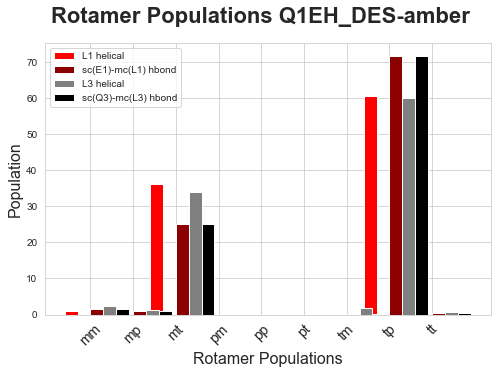

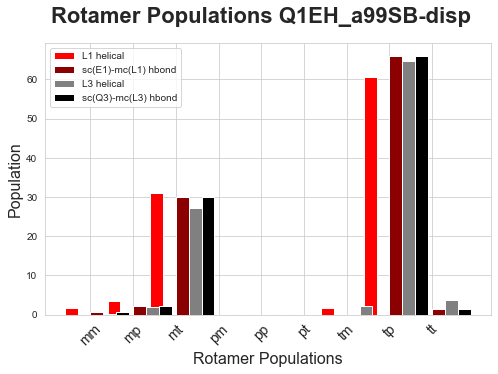

In [31]:
L1_helix_rotamers={}
L1_hbond_rotamers={}
L3_helix_rotamers={}
L3_hbond_rotamers={}

for system in system_list:
    path = f'/home/lourdes/TFM-LOURDES/data/ALL/{system}'
    print (system)
    L1_helix_rotamers[system]=dict_L1_helix(chis1_L1_helix[system],chis2_L1_helix[system])
    L1_hbond_rotamers[system]=dict_L1_hbond(chis1_L1_hbond[system],chis2_L1_hbond[system])
    L3_helix_rotamers[system]=dict_L3_helix(chis1_L3_helix[system],chis2_L3_helix[system])
    L3_hbond_rotamers[system]=dict_L3_hbond(chis1_L3_hbond[system],chis2_L3_hbond[system])
    
    fig = plt.figure(figsize=(8, 5))
    fig.suptitle('Rotamer Populations '+system, fontsize=22, fontweight="bold")
    sns.set_style('whitegrid')
    ind = np.arange(9)
    width = 0.30  
    categories = ['mm','mp','mt','pm','pp','pt','tm','tp','tt']
    
    plt.bar(ind, L1_helix_rotamers[system].values(), width, label="L1 helical", color="red", align="edge")
    plt.bar(ind+2*width, L3_hbond_rotamers[system].values(), width, label="L1 sc(E1)-mc(L1) hbond", color="darkred", align="edge")
    plt.bar(ind+3*width, L3_helix_rotamers[system].values(), width, label="L3 helical", color="grey", align="edge")
    plt.bar(ind+4*width, L3_hbond_rotamers[system].values(), width, label="L3 sc(Q3)-mc(L3) hbond", color="black", align="edge")
    plt.xticks(ind + 2*width, categories, fontsize=14, rotation=45)
    plt.legend(loc="best")
    plt.xlabel('Rotamer Populations', fontsize=16)
    plt.ylabel('Population', fontsize=16)


    

<ipython-input-42-7f9fd28cf7e2>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


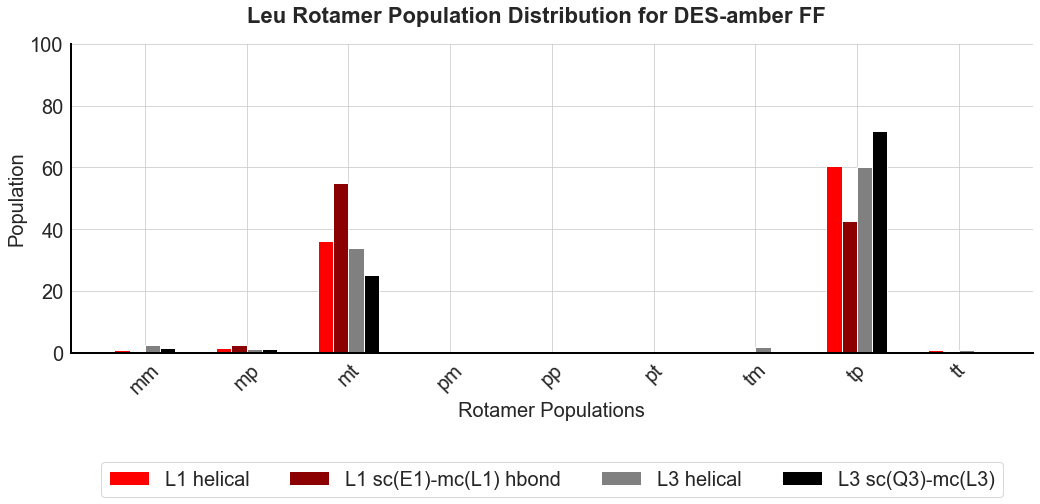

In [42]:
fig = plt.figure(figsize=(15, 8))
sns.set_style('whitegrid')

fig.suptitle('Leu Rotamer Population Distribution for DES-amber FF', fontsize=22, fontweight="bold")
ind = np.arange(9)
width = 0.15 
categories = ['mm','mp','mt','pm','pp','pt','tm','tp','tt']
plt.bar(ind, L1_helix_rotamers['Q1EH_DES-amber'].values(), width, label="L1 helical", color="red", align="edge")
plt.bar(ind+width, L1_hbond_rotamers['Q1EH_DES-amber'].values(), width, label="L1 sc(E1)-mc(L1) hbond", color="darkred", align="edge")
plt.bar(ind+2*width, L3_helix_rotamers['Q1EH_DES-amber'].values(), width, label="L3 helical", color="grey", align="edge")
plt.bar(ind+3*width, L3_hbond_rotamers['Q1EH_DES-amber'].values(), width, label="L3 sc(Q3)-mc(L3)", color="black", align="edge")

plt.xticks(ind + 2*width, categories, fontsize=20, rotation=45)
plt.legend(loc="lower center",bbox_to_anchor=(0.5, -0.5), ncol=4, fontsize=20)
plt.xlabel('Rotamer Populations', fontsize=20)
plt.ylabel('Population', fontsize=20)
plt.ylim(0,100,20)

ax = plt.axes()
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["right"].set_linewidth(2)

ax.spines["bottom"].set_color("k")
ax.spines["left"].set_color("k")
ax.spines["right"].set_color("k")
ax.spines["top"].set_color("k")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(labelsize=20)


plt.tight_layout()

fig.savefig("/home/lourdes/Documents/rotamersLEUCINE_DES-amber.png")


<ipython-input-43-f3fa862a059d>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


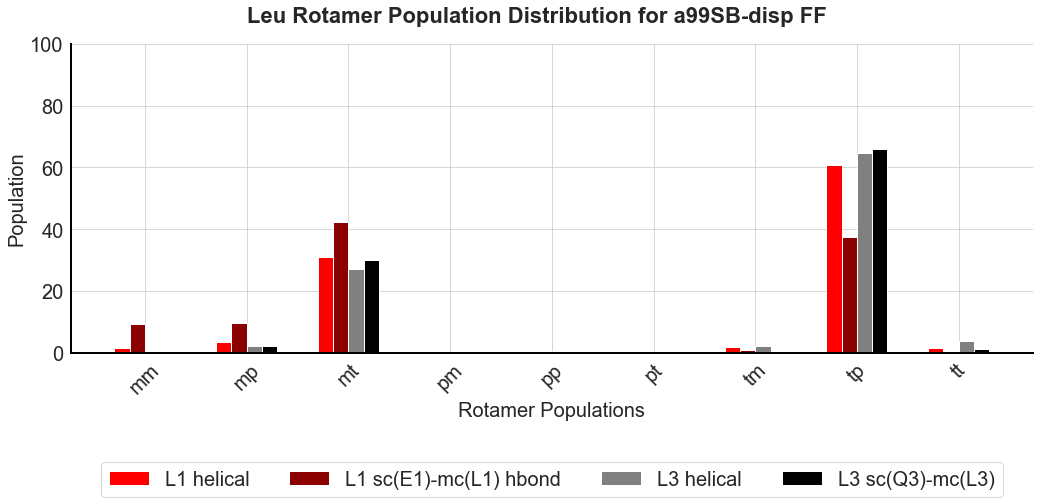

In [43]:
fig = plt.figure(figsize=(15, 8))
sns.set_style('whitegrid')

fig.suptitle('Leu Rotamer Population Distribution for a99SB-disp FF', fontsize=22, fontweight="bold")
ind = np.arange(9)
width = 0.15 
categories = ['mm','mp','mt','pm','pp','pt','tm','tp','tt']
plt.bar(ind, L1_helix_rotamers['Q1EH_a99SB-disp'].values(), width, label="L1 helical", color="red", align="edge")
plt.bar(ind+width, L1_hbond_rotamers['Q1EH_a99SB-disp'].values(), width, label="L1 sc(E1)-mc(L1) hbond", color="darkred", align="edge")
plt.bar(ind+2*width, L3_helix_rotamers['Q1EH_a99SB-disp'].values(), width, label="L3 helical", color="grey", align="edge")
plt.bar(ind+3*width, L3_hbond_rotamers['Q1EH_a99SB-disp'].values(), width, label="L3 sc(Q3)-mc(L3)", color="black", align="edge")

plt.xticks(ind + 2*width, categories, fontsize=20, rotation=45)
plt.legend(loc="lower center",bbox_to_anchor=(0.5, -0.5), ncol=4, fontsize=20)
plt.xlabel('Rotamer Populations', fontsize=20)
plt.ylabel('Population', fontsize=20)
plt.ylim(0,100,20)

ax = plt.axes()
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["right"].set_linewidth(2)

ax.spines["bottom"].set_color("k")
ax.spines["left"].set_color("k")
ax.spines["right"].set_color("k")
ax.spines["top"].set_color("k")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(labelsize=20)


plt.tight_layout()

fig.savefig("/home/lourdes/Documents/rotamersLEUCINE_a99SB-disp.png")



### r3 Kernel Density Analysis

#### The backbone-independent distribution of nonrotameric χ3 of Gln for each of its (χ1, χ2) rotamers. 

Nonrotameric χ3 distributions for Gln are dependent on both the χ1 and χ2 rotamers. The distributions of the nonrotameric degrees of freedom are very broad and asymmetric and cannot be modeled with a rotameric model (Shapovalov & Dunbrack Jr, 2011)

/home/lourdes/miniconda3/envs/TFM/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


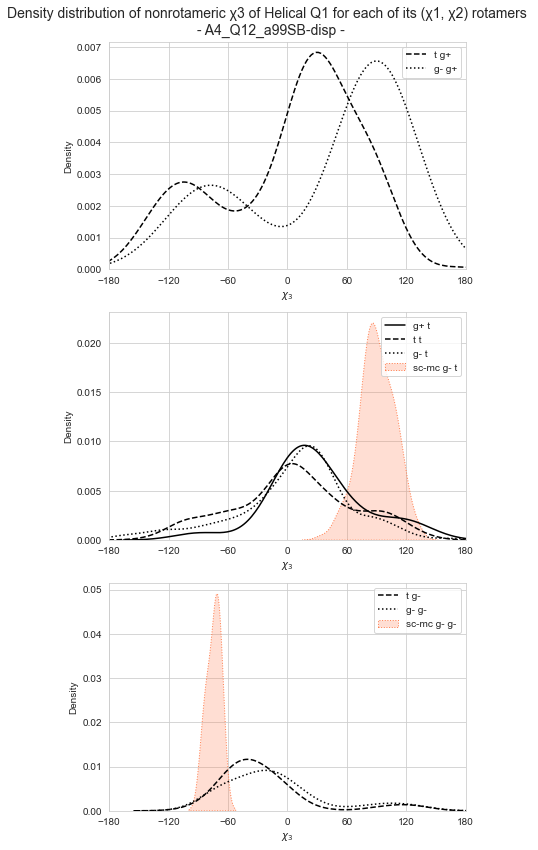

In [27]:
# We are going to use the created dataframes for each Gln condition

# HELICAL Q1 --> dataframe = df_helix

plt.figure(figsize=(6,12)) 
sns.set_style('whitegrid')
plt.suptitle('Density distribution of nonrotameric χ3 of Helical Q1 for each of its (χ1, χ2) rotamers \n - A4_Q12_a99SB-disp -', fontsize=14)
angles = [-180,-120,-60,0,60,120,180]

plt.subplot(311)
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g+g+"'), x="chi3", linestyle="-", label="g+ g+", color="k")
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "tg+"'), x="chi3", linestyle="--", label="t g+",color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-g+"'), x="chi3", linestyle="--", label="sc-mc g- g+",color="coral",shade=True)
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g-g+"'), x="chi3", linestyle=":", label="g- g+",color="k")
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.subplot(312)
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g+t"'), x="chi3", linestyle="-", label="g+ t", color="k")
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "tt"'), x="chi3", linestyle="--", label="t t",color="k")
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g-t"'), x="chi3", linestyle=":", label="g- t",color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-t"'), x="chi3", linestyle=":", label="sc-mc g- t",color="coral", shade=True)
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.subplot(313)
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g+g-"'), x="chi3", linestyle="-", label="g+ g-",color="k")
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "tg-"'), x="chi3", linestyle="--", label="t g-",color="k")
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g-g-"'), x="chi3", linestyle=":", label="g- g-",color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-g-"'), x="chi3", linestyle=":", label="sc-mc g- g-",color="coral",shade=True)
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.tight_layout()

/home/lourdes/miniconda3/envs/TFM/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


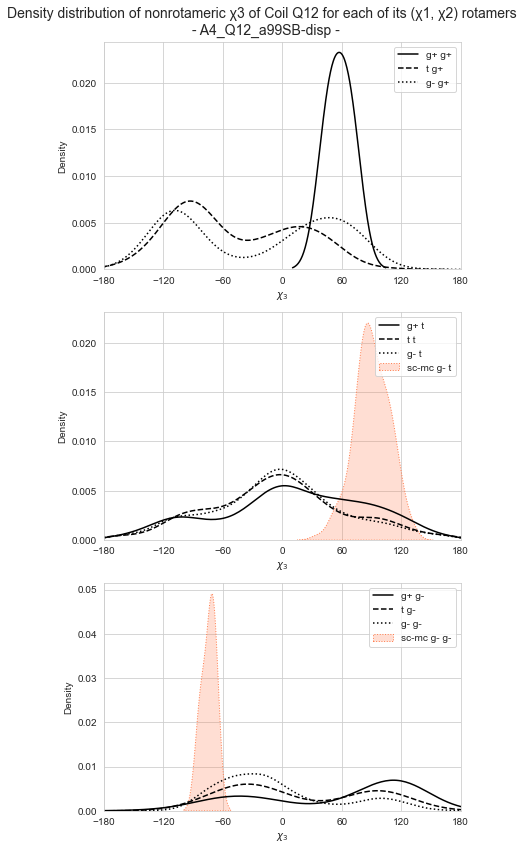

In [28]:
# We are going to use the created dataframes for each Gln condition

# COIL Q12 --> dataframe = df_coil

plt.figure(figsize=(6,12)) 
sns.set_style('whitegrid')
plt.suptitle('Density distribution of nonrotameric χ3 of Coil Q12 for each of its (χ1, χ2) rotamers \n - A4_Q12_a99SB-disp -', fontsize=14)
angles = [-180,-120,-60,0,60,120,180]

plt.subplot(311)
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g+g+"'), x="chi3", linestyle="-", label="g+ g+", color="k")
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "tg+"'), x="chi3", linestyle="--", label="t g+",color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-g+"'), x="chi3", linestyle="--", label="sc-mc g- g+",color="coral",shade=True)
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g-g+"'), x="chi3", linestyle=":", label="g- g+",color="k")
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.subplot(312)
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g+t"'), x="chi3", linestyle="-", label="g+ t", color="k")
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "tt"'), x="chi3", linestyle="--", label="t t",color="k")
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g-t"'), x="chi3", linestyle=":", label="g- t",color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-t"'), x="chi3", linestyle=":", label="sc-mc g- t",color="coral", shade=True)
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.subplot(313)
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g+g-"'), x="chi3", linestyle="-", label="g+ g-",color="k")
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "tg-"'), x="chi3", linestyle="--", label="t g-",color="k")
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g-g-"'), x="chi3", linestyle=":", label="g- g-",color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-g-"'), x="chi3", linestyle=":", label="sc-mc g- g-",color="coral", shade=True)
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.tight_layout()